# Pairwise Order relation

## Set Up

In [1]:
import sys
sys.path.append('../..'); sys.path.append('../');

import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf

import itertools

import utils

from tqdm import tqdm, trange
import wandb

import plotly.express as px

## Object Dataset

In [2]:
# create data set for learning order relatios
# num_objects = 32
# object_dim = 8
num_objects = 64
object_dim = 32
object_pairs = np.array(list(itertools.permutations(range(num_objects), r=2)))
object_order_relations = (object_pairs[:,0] < object_pairs[:, 1]).astype(int)
sample = np.random.choice(len(object_pairs), 10)
for object_pair, relation in zip(object_pairs[sample], object_order_relations[sample]):
    print(f'object pair: {tuple(object_pair)}; relation: {relation}')

object pair: (24, 18); relation: 0
object pair: (20, 54); relation: 1
object pair: (38, 23); relation: 0
object pair: (38, 2); relation: 0
object pair: (56, 8); relation: 0
object pair: (33, 36); relation: 1
object pair: (24, 49); relation: 1
object pair: (38, 55); relation: 1
object pair: (29, 20); relation: 0
object pair: (11, 13); relation: 1


In [3]:
objects = np.random.normal(loc=0., scale=1., size=(num_objects, object_dim))

X = objects[object_pairs]
y = object_order_relations

In [4]:
X.shape, y.shape, y.mean()

((4032, 2, 32), (4032,), 0.5)

In [5]:
from sklearn.model_selection import train_test_split
test_size = 0.35
val_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size/(1-test_size))

In [6]:
len(y_train), len(y_val), len(y_test)

(2015, 605, 1412)

In [7]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

## Abstractor

In [8]:
from abstractor import Abstractor
from tensorflow.keras import layers

In [9]:
embedding_dim = 64

abstractor_kwargs = dict(
        num_layers=1,
        rel_dim=4,
        symbol_dim=64,
        proj_dim=16,
        dff=64,
        symmetric_rels=False,
        encoder_kwargs=dict(use_bias=False),
        rel_activation_type='sigmoid',
        use_self_attn=False,
        use_layer_norm=False,
        dropout_rate=0.1,)

orderabstractor_kwargs = dict(embedding_dim=embedding_dim, abstractor_kwargs=abstractor_kwargs)

class AbstractorOrderModel(tf.keras.Model):
    def __init__(self, embedding_dim, abstractor_kwargs, name=None):
        super().__init__(name=name)
        self.embedder = layers.Dense(embedding_dim)
        self.abstractor = Abstractor(**abstractor_kwargs)
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')

    def call(self, inputs):
        x = self.embedder(inputs)
        x = self.abstractor(x)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

    def print_summary(self, input_shape):
        inputs = layers.Input(input_shape)
        outputs = self.call(inputs)
        print(tf.keras.Model(inputs, outputs, name=self.name).summary())

abstractor_model = AbstractorOrderModel(**orderabstractor_kwargs, name='order_abstractor')
abstractor_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
abstractor_model(X_train[:32])
abstractor_model.print_summary(X.shape[1:]);

Model: "order_abstractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 32)]           0         
                                                                 
 dense (Dense)               (None, 2, 64)             2112      
                                                                 
 abstractor (Abstractor)     (None, 2, 64)             20928     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 hidden_layer (Dense)        (None, 32)                4128      
                                                                 
 final_layer (Dense)         (None, 1)                 33        
                                                                 
Total params: 27,201
Trainable params: 27,201
Non-

In [10]:
train_size = 400
X_train_, y_train_ = X_train[:train_size], y_train[:train_size]
history = abstractor_model.fit(X_train_, y_train_, validation_data=(X_val, y_val),
    verbose=1, epochs=100, batch_size=64)

Epoch 1/100
7/7 [==============================] - 5s 175ms/step - loss: 0.7268 - binary_accuracy: 0.5350 - val_loss: 0.7128 - val_binary_accuracy: 0.5438
Epoch 2/100
7/7 [==============================] - 0s 26ms/step - loss: 0.6518 - binary_accuracy: 0.5875 - val_loss: 0.6947 - val_binary_accuracy: 0.5570
Epoch 3/100
7/7 [==============================] - 0s 28ms/step - loss: 0.5989 - binary_accuracy: 0.7075 - val_loss: 0.7033 - val_binary_accuracy: 0.5686
Epoch 4/100
7/7 [==============================] - 0s 25ms/step - loss: 0.5597 - binary_accuracy: 0.7025 - val_loss: 0.7058 - val_binary_accuracy: 0.5983
Epoch 5/100
7/7 [==============================] - 0s 26ms/step - loss: 0.4967 - binary_accuracy: 0.7450 - val_loss: 0.7242 - val_binary_accuracy: 0.6116
Epoch 6/100
7/7 [==============================] - 0s 23ms/step - loss: 0.4407 - binary_accuracy: 0.8050 - val_loss: 0.7175 - val_binary_accuracy: 0.6430
Epoch 7/100
7/7 [==============================] - 0s 23ms/step - loss: 0.3

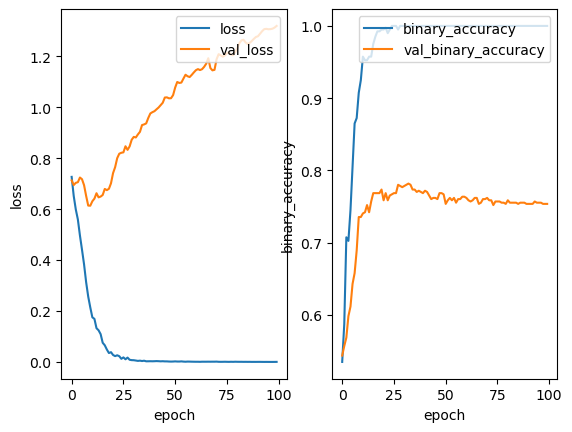

In [11]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [12]:
abstractor_model.evaluate(X_train, y_train)

63/63 [==============================] - 0s 4ms/step - loss: 1.2440 - binary_accuracy: 0.7856


[1.2439626455307007, 0.7856079339981079]

In [13]:
abstractor_model.evaluate(X_test, y_test)

45/45 [==============================] - 0s 4ms/step - loss: 1.5928 - binary_accuracy: 0.7174


[1.5927987098693848, 0.7174220681190491]

## MLP

In [14]:
from tensorflow.keras import layers

In [15]:
embedding_dim = 64
mlp_kwargs = dict(embedding_dim=embedding_dim, h1=32, h2=32)

class MLPModel(tf.keras.Model):
    def __init__(self, embedding_dim, h1, h2, name=None):
        super().__init__(name=name)
        self.flatten = layers.Flatten()
        self.hidden_dense1 = layers.Dense(h1, activation='relu', name='hidden_layer1')
        self.hidden_dense2 = layers.Dense(h2, activation='relu', name='hidden_layer2')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')

    def call(self, inputs):
        # x = self.embedder(inputs)
        x = inputs
        x = self.flatten(x)
        x = self.hidden_dense1(x)
        x = self.hidden_dense2(x)
        x = self.final_layer(x)

        return x

    def print_summary(self, input_shape):
        inputs = layers.Input(input_shape)
        outputs = self.call(inputs)
        print(tf.keras.Model(inputs, outputs).summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

mlp_model = MLPModel(**mlp_kwargs, name='mlp')
mlp_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy']);
mlp_model(X_train[:32]);
mlp_model.print_summary(X.shape[1:]);

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 32)]           0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 hidden_layer1 (Dense)       (None, 32)                2080      
                                                                 
 hidden_layer2 (Dense)       (None, 32)                1056      
                                                                 
 final_layer (Dense)         (None, 1)                 33        
                                                                 
Total params: 3,169
Trainable params: 3,169
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
train_size = 400
X_train_, y_train_ = X_train[:train_size], y_train[:train_size]
history = mlp_model.fit(X_train_, y_train_, validation_data=(X_val, y_val),
    verbose=1, epochs=100, batch_size=64)

Epoch 1/100
7/7 [==============================] - 1s 58ms/step - loss: 0.7557 - binary_accuracy: 0.5175 - val_loss: 0.7506 - val_binary_accuracy: 0.4959
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 0.6912 - binary_accuracy: 0.5725 - val_loss: 0.7209 - val_binary_accuracy: 0.5455
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 0.6552 - binary_accuracy: 0.5975 - val_loss: 0.7031 - val_binary_accuracy: 0.5570
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 0.6275 - binary_accuracy: 0.6425 - val_loss: 0.6881 - val_binary_accuracy: 0.5653
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 0.6029 - binary_accuracy: 0.6900 - val_loss: 0.6747 - val_binary_accuracy: 0.5802
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 0.5798 - binary_accuracy: 0.7350 - val_loss: 0.6633 - val_binary_accuracy: 0.5950
Epoch 7/100
7/7 [==============================] - 0s 12ms/step - loss: 0.55

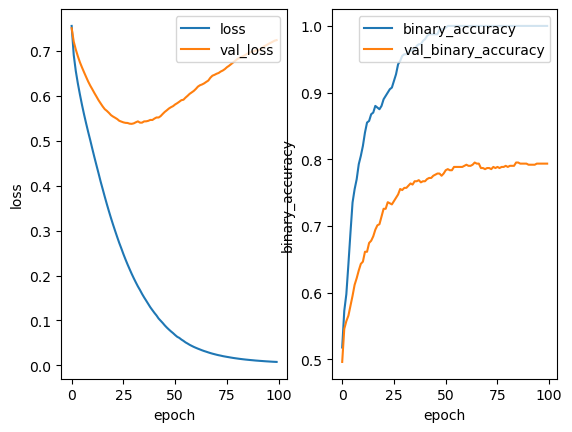

In [17]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [18]:
mlp_model.evaluate(X_train, y_train)

63/63 [==============================] - 0s 3ms/step - loss: 0.6047 - binary_accuracy: 0.8228


[0.6047059297561646, 0.8228287696838379]

In [19]:
mlp_model.evaluate(X_test, y_test)

45/45 [==============================] - 0s 2ms/step - loss: 0.7765 - binary_accuracy: 0.7677


[0.7765435576438904, 0.7677053809165955]

## PrediNet

In [20]:
from tensorflow.keras import layers
from baseline_models.predinet import PrediNet

In [21]:
embedding_dim = 64
predinet_kwargs = dict(embedding_dim=embedding_dim, predinet_kwargs=dict(key_dim=4, n_heads=4, n_relations=16, add_temp_tag=False))

class PrediNetModel(tf.keras.Model):
    def __init__(self, embedding_dim, predinet_kwargs, name=None):
        super().__init__(name=name)
        self.flatten = layers.Flatten()
        self.predinet = PrediNet(**predinet_kwargs)
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')

    def call(self, inputs):
        x = self.predinet(inputs)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)
        return x

    def print_summary(self, input_shape):
        inputs = layers.Input(input_shape)
        outputs = self.call(inputs)
        print(tf.keras.Model(inputs, outputs).summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

predinet_model = PrediNetModel(**predinet_kwargs, name='predinet')
predinet_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy']);
predinet_model(X_train[:32]);
predinet_model.print_summary(X.shape[1:]);

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 32)]           0         
                                                                 
 predi_net (PrediNet)        (None, 64)                2688      
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 hidden_layer (Dense)        (None, 32)                2080      
                                                                 
 final_layer (Dense)         (None, 1)                 33        
                                                                 
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
train_size = 400
X_train_, y_train_ = X_train[:train_size], y_train[:train_size]
history = predinet_model.fit(X_train_, y_train_, validation_data=(X_val, y_val),
    verbose=1, epochs=100, batch_size=64)

Epoch 1/100
7/7 [==============================] - 3s 100ms/step - loss: 0.7998 - binary_accuracy: 0.4575 - val_loss: 0.7704 - val_binary_accuracy: 0.5058
Epoch 2/100
7/7 [==============================] - 0s 16ms/step - loss: 0.7271 - binary_accuracy: 0.5225 - val_loss: 0.7531 - val_binary_accuracy: 0.5124
Epoch 3/100
7/7 [==============================] - 0s 16ms/step - loss: 0.6833 - binary_accuracy: 0.5650 - val_loss: 0.7415 - val_binary_accuracy: 0.5174
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 0.6483 - binary_accuracy: 0.6100 - val_loss: 0.7313 - val_binary_accuracy: 0.5174
Epoch 5/100
7/7 [==============================] - 0s 18ms/step - loss: 0.6201 - binary_accuracy: 0.6850 - val_loss: 0.7240 - val_binary_accuracy: 0.5289
Epoch 6/100
7/7 [==============================] - 0s 18ms/step - loss: 0.5960 - binary_accuracy: 0.7225 - val_loss: 0.7175 - val_binary_accuracy: 0.5339
Epoch 7/100
7/7 [==============================] - 0s 15ms/step - loss: 0.5

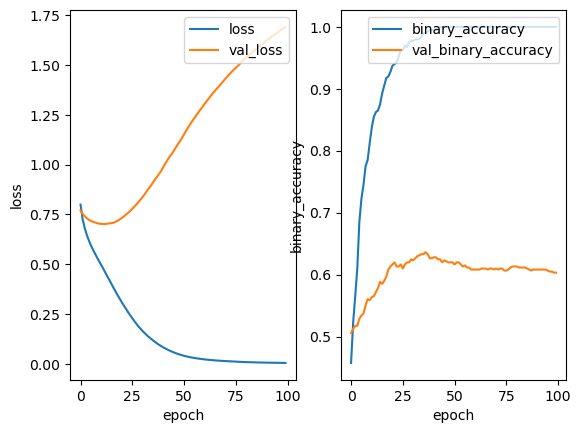

In [23]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [24]:
predinet_model.evaluate(X_train, y_train)

63/63 [==============================] - 0s 4ms/step - loss: 1.2114 - binary_accuracy: 0.7002


[1.2114335298538208, 0.700248122215271]

In [25]:
predinet_model.evaluate(X_test, y_test)

45/45 [==============================] - 0s 3ms/step - loss: 1.4721 - binary_accuracy: 0.6516


[1.4720784425735474, 0.6515581011772156]

## CorelNet (Symmetric; Stanard)

In [26]:
from multi_head_relation import MultiHeadRelation
from tensorflow.keras import layers

In [27]:
embedding_dim = 64
ordercorelnet_kwargs = dict(embedding_dim=embedding_dim)

class CorelNetModel(tf.keras.Model):
    def __init__(self, embedding_dim, name=None):
        super().__init__(name=name)
        self.embedder = layers.Dense(embedding_dim)
        self.mhr = MultiHeadRelation(rel_dim=1, proj_dim=None, symmetric=True, dense_kwargs=dict(use_bias=False))
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')

    def call(self, inputs):
        x = self.embedder(inputs)
        x = self.mhr(x)
        x = tf.nn.softmax(x, axis=1)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

    def print_summary(self, input_shape):
        inputs = layers.Input(input_shape)
        outputs = self.call(inputs)
        print(tf.keras.Model(inputs, outputs).summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

corelnet_model = CorelNetModel(**ordercorelnet_kwargs, name='order_corelnet')
corelnet_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
corelnet_model(X_train[:32]);
corelnet_model.print_summary(X.shape[1:]);

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2, 32)]           0         
                                                                 
 dense_19 (Dense)            (None, 2, 64)             2112      
                                                                 
 multi_head_relation_1 (Mult  (None, 2, 2, 1)          4096      
 iHeadRelation)                                                  
                                                                 
 tf.nn.softmax (TFOpLambda)  (None, 2, 2, 1)           0         
                                                                 
 flatten_5 (Flatten)         (None, 4)                 0         
                                                                 
 hidden_layer (Dense)        (None, 32)                160       
                                                           

In [28]:
train_size = 400
X_train_, y_train_ = X_train[:train_size], y_train[:train_size]
history = corelnet_model.fit(X_train_, y_train_, validation_data=(X_val, y_val),
    verbose=1, epochs=100, batch_size=64)

Epoch 1/100
7/7 [==============================] - 2s 92ms/step - loss: 0.6939 - binary_accuracy: 0.4475 - val_loss: 0.6932 - val_binary_accuracy: 0.5041
Epoch 2/100
7/7 [==============================] - 0s 13ms/step - loss: 0.6930 - binary_accuracy: 0.5025 - val_loss: 0.6933 - val_binary_accuracy: 0.5041
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 0.6928 - binary_accuracy: 0.4900 - val_loss: 0.6935 - val_binary_accuracy: 0.4926
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 0.6927 - binary_accuracy: 0.5025 - val_loss: 0.6934 - val_binary_accuracy: 0.4926
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 0.6925 - binary_accuracy: 0.5025 - val_loss: 0.6934 - val_binary_accuracy: 0.4926
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 0.6925 - binary_accuracy: 0.5025 - val_loss: 0.6935 - val_binary_accuracy: 0.4926
Epoch 7/100
7/7 [==============================] - 0s 15ms/step - loss: 0.69

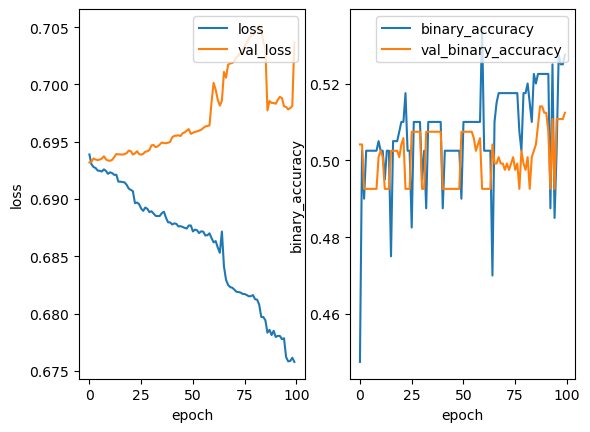

In [29]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [30]:
corelnet_model.evaluate(X_train, y_train)

63/63 [==============================] - 0s 2ms/step - loss: 0.6994 - binary_accuracy: 0.5027


[0.6994447112083435, 0.5027295351028442]

In [31]:
corelnet_model.evaluate(X_test, y_test)

45/45 [==============================] - 0s 3ms/step - loss: 0.7177 - binary_accuracy: 0.4901


[0.7176824808120728, 0.4900849759578705]

## CorelNet (Asymmetric)

In [32]:
from multi_head_relation import MultiHeadRelation
from tensorflow.keras import layers

In [33]:
embedding_dim = 64
ordercorelnet_kwargs = dict(embedding_dim=embedding_dim)

class CorelNetModelAsymmetric(tf.keras.Model):
    def __init__(self, embedding_dim, name=None):
        super().__init__(name=name)
        self.embedder = layers.Dense(embedding_dim)
        self.mhr = MultiHeadRelation(rel_dim=1, proj_dim=None, symmetric=False, dense_kwargs=dict(use_bias=False))
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')

    def call(self, inputs):
        x = self.embedder(inputs)
        x = self.mhr(x)
        x = tf.nn.softmax(x, axis=1)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

    def print_summary(self, input_shape):
        inputs = layers.Input(input_shape)
        outputs = self.call(inputs)
        print(tf.keras.Model(inputs, outputs).summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

corelnet_model = CorelNetModelAsymmetric(**ordercorelnet_kwargs, name='order_corelnet')
corelnet_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
corelnet_model(X_train[:32]);
corelnet_model.print_summary(X.shape[1:]);

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2, 32)]           0         
                                                                 
 dense_21 (Dense)            (None, 2, 64)             2112      
                                                                 
 multi_head_relation_2 (Mult  (None, 2, 2, 1)          8192      
 iHeadRelation)                                                  
                                                                 
 tf.nn.softmax_1 (TFOpLambda  (None, 2, 2, 1)          0         
 )                                                               
                                                                 
 flatten_6 (Flatten)         (None, 4)                 0         
                                                                 
 hidden_layer (Dense)        (None, 32)                160 

In [34]:
train_size = 400
X_train_, y_train_ = X_train[:train_size], y_train[:train_size]
history = corelnet_model.fit(X_train_, y_train_, validation_data=(X_val, y_val),
    verbose=1, epochs=100, batch_size=64)

Epoch 1/100
7/7 [==============================] - 3s 135ms/step - loss: 0.6933 - binary_accuracy: 0.5050 - val_loss: 0.6886 - val_binary_accuracy: 0.5570
Epoch 2/100
7/7 [==============================] - 0s 16ms/step - loss: 0.6731 - binary_accuracy: 0.6225 - val_loss: 0.6800 - val_binary_accuracy: 0.5752
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 0.6568 - binary_accuracy: 0.6825 - val_loss: 0.6729 - val_binary_accuracy: 0.6050
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 0.6393 - binary_accuracy: 0.7250 - val_loss: 0.6624 - val_binary_accuracy: 0.6165
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 0.6213 - binary_accuracy: 0.7575 - val_loss: 0.6508 - val_binary_accuracy: 0.6446
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 0.6023 - binary_accuracy: 0.7750 - val_loss: 0.6404 - val_binary_accuracy: 0.6545
Epoch 7/100
7/7 [==============================] - 0s 18ms/step - loss: 0.5

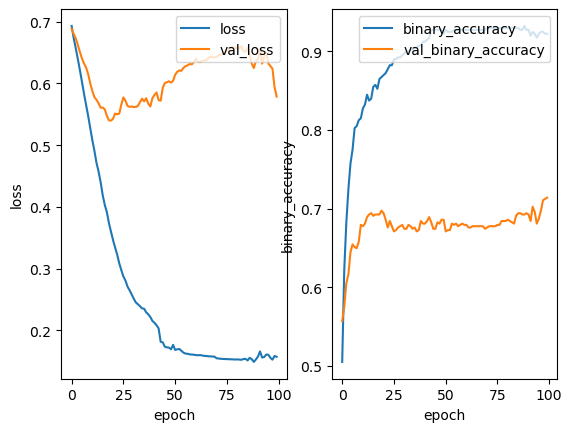

In [35]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [36]:
corelnet_model.evaluate(X_train, y_train)

63/63 [==============================] - 0s 3ms/step - loss: 0.5142 - binary_accuracy: 0.7628


[0.5141657590866089, 0.762779176235199]

In [37]:
corelnet_model.evaluate(X_test, y_test)

45/45 [==============================] - 0s 3ms/step - loss: 0.6895 - binary_accuracy: 0.7082


[0.6894798874855042, 0.7082152962684631]

## Learning curve evaluation

In [38]:
def create_callbacks(use_wandb=False, patience=10):
    callbacks = []
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
        patience=patience, min_delta=1e-2, baseline=0.6, mode='auto',
        restore_best_weights=True, verbose=False))
    if use_wandb: callbacks.append(wandb.keras.WandbMetricsLogger(log_freq='epoch'))
    return callbacks

def evaluate_model(model, X_test, y_test):
    eval_dict = model.evaluate(X_test, y_test, return_dict=True, verbose=False)
    return eval_dict

def log_to_wandb(evaluation_dict):
    wandb.log(evaluation_dict)

In [39]:
start_trial = 0
wandb_project_name = 'abstractor_pairwise_order'

fit_kwargs = {'epochs': 100, 'batch_size': 64}

def evaluate_learning_curves(
    create_model, group_name,
    X_train, y_train, X_val, y_val, X_test, y_test,
    train_sizes, num_trials, use_wandb=False):

    eval_dicts =[]

    for train_size in tqdm(train_sizes, desc='train size'):

        for trial in trange(start_trial, start_trial + num_trials, desc='trial', leave=False):

            if use_wandb:
                run = wandb.init(project=wandb_project_name, group=group_name, name=f'train size = {train_size}; trial = {trial}',
                    config={'train size': train_size, 'trial': trial, 'group': group_name})
            model = create_model()

            sample_idx = np.random.choice(len(X_train), train_size, replace=False)
            X_train_ = X_train[sample_idx]
            y_train_ = y_train[sample_idx]

            history = model.fit(X_train_, y_train_, validation_data=(X_val, y_val), verbose=0,
                callbacks=create_callbacks(use_wandb=use_wandb), **fit_kwargs)

            eval_dict = evaluate_model(model, X_test, y_test)

            if use_wandb:
                log_to_wandb(eval_dict)
                wandb.finish(quiet=True)

            eval_dict.update({'group': group_name, 'train_size': train_size, 'trial': trial})
            eval_dicts.append(eval_dict)

            del model

    return eval_dicts


In [40]:
def create_abstractor():
    abstractor_model = AbstractorOrderModel(**orderabstractor_kwargs, name='order_abstractor')
    abstractor_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
    abstractor_model(X_train[:32])

    return abstractor_model

def create_mlp():
    mlp_model = MLPModel(**mlp_kwargs, name='mlp')
    mlp_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy']);
    mlp_model(X_train[:32]);
    return mlp_model

def create_predinet():
    predinet_model = PrediNetModel(**predinet_kwargs, name='predinet')
    predinet_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy']);
    predinet_model(X_train[:32]);
    return predinet_model

def create_corelnet():
    corelnet_model = CorelNetModel(**ordercorelnet_kwargs, name='order_corelnet')
    corelnet_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
    corelnet_model(X_train[:32])
    return corelnet_model

def create_asymmetric_corelnet():
    corelnet_model = CorelNetModelAsymmetric(**ordercorelnet_kwargs, name='order_corelnet')
    corelnet_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
    corelnet_model(X_train[:32])
    return corelnet_model


In [41]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: agastyasamayrana. Use `wandb login --relogin` to force relogin


True

In [42]:
num_trials = 10
train_sizes = [5, 100, 200, 500, 1000, 1500, len(X_train)]

print('evaluating abstractor')

abstractor_eval_dicts = evaluate_learning_curves(
    create_abstractor, 'abstractor',
    X_train, y_train, X_val, y_val, X_test, y_test,
    train_sizes, num_trials, use_wandb=False)

print('evaluating MLP')

mlp_eval_dicts = evaluate_learning_curves(
    create_corelnet, 'mlp',
    X_train, y_train, X_val, y_val, X_test, y_test,
    train_sizes, num_trials, use_wandb=False)

print('evaluating PrediNet')

predinet_eval_dicts = evaluate_learning_curves(
    create_predinet, 'predinet',
    X_train, y_train, X_val, y_val, X_test, y_test,
    train_sizes, num_trials, use_wandb=False)

print('evaluating corelnet')

corelnet_eval_dicts = evaluate_learning_curves(
    create_corelnet, 'corelnet',
    X_train, y_train, X_val, y_val, X_test, y_test,
    train_sizes, num_trials, use_wandb=False)

print('evaluating asymmetric corelnet')

asymcorelnet_eval_dicts = evaluate_learning_curves(
    create_asymmetric_corelnet, 'asymmetric_corelnet',
    X_train, y_train, X_val, y_val, X_test, y_test,
    train_sizes, num_trials, use_wandb=False)


evaluating abstractor


train size: 100%|██████████| 7/7 [08:50<00:00, 75.81s/it]


evaluating MLP


train size: 100%|██████████| 7/7 [03:17<00:00, 28.22s/it]


evaluating PrediNet


train size: 100%|██████████| 7/7 [04:17<00:00, 36.79s/it]


evaluating corelnet


train size: 100%|██████████| 7/7 [03:30<00:00, 30.14s/it]


evaluating asymmetric corelnet


train size: 100%|██████████| 7/7 [05:09<00:00, 44.28s/it]


In [43]:
import pandas as pd
dfs = [pd.DataFrame(eval_dict) for eval_dict in (abstractor_eval_dicts, mlp_eval_dicts, predinet_eval_dicts, corelnet_eval_dicts, asymcorelnet_eval_dicts)]
learning_curves_df = pd.concat(dfs)
learning_curves_df

,loss,binary_accuracy,group,train_size,trial
0,0.731912,0.524788,abstractor,5,0
1,0.699542,0.529745,abstractor,5,1
2,0.771320,0.480878,abstractor,5,2
3,0.734152,0.513456,abstractor,5,3
4,0.766206,0.509207,abstractor,5,4
...,...,...,...,...,...
65,0.312104,0.827904,asymmetric_corelnet,2015,5
66,0.250696,0.859065,asymmetric_corelnet,2015,6
67,0.258037,0.843484,asymmetric_corelnet,2015,7
68,0.280612,0.854108,asymmetric_corelnet,2015,8


In [44]:
import datetime
datetimestr = datetime.datetime.now().strftime("%Y-%m-%d-%H%M")
learning_curves_df.to_csv(f'learning_curves_data_{datetimestr}.csv')

In [45]:
%%capture
import scipy
learning_curves_agg_df = learning_curves_df.groupby(['group', 'train_size'])
metrics = ['binary_accuracy']
learning_curves_agg_df = learning_curves_agg_df[metrics].agg(
    [np.mean, np.max, scipy.stats.sem, len])
learning_curves_agg_df = learning_curves_agg_df.reset_index()
learning_curves_agg_df.columns = [' '.join(col).strip() for col in learning_curves_agg_df.columns.values]

In [46]:
metric = 'binary_accuracy'
fig = px.line(learning_curves_agg_df, color='group', symbol='group',
    x='train_size', y=f'{metric} mean', error_y=f'{metric} sem', hover_data=[f'{metric} len'],
    labels={f'{metric} len': '# of trials', f'{metric} mean': metric, 'group': 'Model', 'train_size': 'Training Set Size'},
    title='Pairwise Order Relation Learning Curves', width=1000, height=600)
# fig.write_html(f'figs/object_argsort_{metric}_learning_curves.html')
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[10],
                                   [10],
                                   [10],
                                   [10],
                                   [10],
                                   [10],
                                   [10]], dtype=int64),
              'error_y': {'array': array([0.00581024, 0.01594986, 0.01653035, 0.00765401, 0.00463261, 0.00487138,
                                          0.00510423])},
              'hovertemplate': ('Model=abstractor<br>Training S' ... '{customdata[0]}<extra></extra>'),
              'legendgroup': 'abstractor',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'abstractor',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([   5,  100,  200,  500, 1000, 1500, 2015], dtype=int64),
              'xaxis': 'x',
              'y': array([0.5111898 , 0.55481587, 0.64532578, 0.80616147, 0.86961756, 0.9003541 ,
                          0.92075071]),
              'yaxis': 'y'},
             {'customdata': array([[10],
                                   [10],
                                   [10],
                                   [10],
                                   [10],
                                   [10],
                                   [10]], dtype=int64),
              'error_y': {'array': array([0.00789398, 0.01221192, 0.01907314, 0.03511694, 0.0291363 , 0.00243063,
                                          0.00558069])},
              'hovertemplate': ('Model=asymmetric_corelnet<br>T' ... '{customdata[0]}<extra></extra>'),
              'legendgroup': 'asymmetric_corelnet',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'diamond'},
              'mode': 'lines+markers',
              'name': 'asymmetric_corelnet',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([   5,  100,  200,  500, 1000, 1500, 2015], dtype=int64),
              'xaxis': 'x',
              'y': array([0.50906516, 0.51614732, 0.56048159, 0.63116146, 0.75949008, 0.81324363,
                          0.83881021]),
              'yaxis': 'y'},
             {'customdata': array([[10],
                                   [10],
                                   [10],
                                   [10],
                                   [10],
                                   [10],
                                   [10]], dtype=int64),
              'error_y': {'array': array([0.00060464, 0.00064909, 0.00057633, 0.00067766, 0.00346761, 0.00796668,
                                          0.01846196])},
              'hovertemplate': ('Model=corelnet<br>Training Set' ... '{customdata[0]}<extra></extra>'),
              'legendgroup': 'corelnet',
              'line': {'color': '#00cc96', 'dash': 'solid'},
              'marker': {'symbol': 'square'},
              'mode': 'lines+markers',
              'name': 'corelnet',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([   5,  100,  200,  500, 1000, 1500, 2015], dtype=int64),
              'xaxis': 'x',
              'y': array([0.49915015, 0.50056659, 0.49915015, 0.4990085 , 0.50410766, 0.51026912,
                          0.55169972]),
              'yaxis': 'y'},
             {'customdata': array([[10],
                                   [10],
                                   [10],
                                   [10],
                                   [10],
                                   [10],
                                   [10]], dtype=int64),
              'error_y': {'array': array([0.00067436, 0.00073751, 0.00077437, 0.00069591, 0.00081128, 0.01061749,
                 